In [1]:
import numpy as np
#from scipy.interpolate import griddata, LinearNDInterpolator, NearestNDInterpolator
#from scipy.ndimage import generic_filter
from scipy.interpolate import griddata, Rbf
import matplotlib.pyplot as plt
import xmitgcm
import sys
sys.path.append('/home3/sreich/MITgcm_c68w/MITgcm/utils/python/MITgcmutils')
from MITgcmutils import rdmds

sys.path.append('/home3/sreich/jupyter/jupyter_notebooks')
from read_write import *
from patchface3D import *

In [2]:
nx=90
ny=nx*13
nz=50

factor = 3 # lowres * factor = hires

nxh=nx*factor
nyh=ny*factor

iter = '0001'

#dirroot='/nobackup/sreich/multigrid_test_ou/c68w/'
dirroot='/nobackup/sreich/multigrid_jpl_obsfit/'

dirrun_lr = dirroot + 'llc90/run.v4_rls4.077d3.iter0.swot1992.adj.lr_cost/'
dirrun_hr = dirroot + 'llc270/run.fwd_270.076c.swot1992.iter0/'
#dirrun_hr = '/nobackup/sreich/llc270_c68w_runs/run_pk0000841536_1200s/'

dirrun_pup_lr_cost = dirroot + 'llc90/run.v4_rls4.077d3.swot1992.pack_unpack_iter1.lr_cost/'
dirrun_pup = dirroot + 'llc90/run.v4_rls4.077d3.swot1992.pack_unpack_iter1/'
#dirrun_pup = dirroot + 'llc90/run.v4_rls4.077d3_fwd_90.pack_unpack/'

In [3]:
# read in unpacked low-res adjustments

# xx_aqh = rdmds(dirrun_pup + 'xx_aqh.000000' + iter)
# xx_atemp = rdmds(dirrun_pup + 'xx_atemp.000000' + iter)
# xx_diffkr = rdmds(dirrun_pup + 'xx_diffkr.000000' + iter)
# xx_etan = rdmds(dirrun_pup + 'xx_etan.000000' + iter)
# xx_kapgm = rdmds(dirrun_pup + 'xx_kapgm.000000' + iter)
# xx_kapredi = rdmds(dirrun_pup + 'xx_kapredi.000000' + iter)
# xx_lwdown = rdmds(dirrun_pup + 'xx_lwdown.000000' + iter)
# xx_precip = rdmds(dirrun_pup + 'xx_precip.000000' + iter)
# xx_swdown = rdmds(dirrun_pup + 'xx_swdown.000000' + iter)
# xx_tauu = rdmds(dirrun_pup + 'xx_tauu.000000' + iter)
# xx_tauv = rdmds(dirrun_pup + 'xx_tauv.000000' + iter)
# xx_uvel = rdmds(dirrun_pup + 'xx_uvel.000000' + iter)
# xx_vvel = rdmds(dirrun_pup + 'xx_vvel.000000' + iter)

xx_salt = rdmds(dirrun_pup + 'xx_salt.000000' + iter)
xx_theta = rdmds(dirrun_pup + 'xx_theta.000000' + iter)

xx_salt_lrcost = rdmds(dirrun_pup_lr_cost + 'xx_salt.000000' + iter)
xx_theta_lrcost = rdmds(dirrun_pup_lr_cost + 'xx_theta.000000' + iter)

np.unique(xx_theta - xx_theta_lrcost)

array([-0.00143238, -0.00128983, -0.00119561, ...,  0.00100354,
        0.00102714,  0.00105179])

In [4]:
# xx_all = [xx_aqh, xx_atemp, xx_diffkr, xx_etan, xx_kapgm, xx_kapredi, xx_lwdown, xx_precip, 
#             xx_salt, xx_swdown, xx_tauu, xx_tauv, xx_theta, xx_uvel, xx_vvel]
xx_all = [xx_salt, xx_theta, xx_salt_lrcost, xx_theta_lrcost]

for arr in xx_all:
    print(np.min(arr), np.max(arr))

-0.008230670355260372 0.012439627200365067
-0.00010996923811035231 0.00014976091915741563
-0.08695221692323685 0.131417378783226
-0.001161760650575161 0.0015821364941075444


In [5]:
# read in high-res and low-res grids

xc_lr = rdmds(dirrun_lr + 'XC')
yc_lr = rdmds(dirrun_lr + 'YC')

xc_hr = rdmds(dirrun_hr + 'XC')
yc_hr = rdmds(dirrun_hr + 'YC')
#yc_hr = grid_270.YC.values.reshape(nyh, nxh)

hfacc_hr = rdmds(dirrun_hr + 'hFacC')
maskc_hr = rdmds(dirrun_hr + 'maskCtrlC')

xc_lr.shape, maskc_hr.shape

((1170, 90), (50, 3510, 270))

In [32]:
def linear_interp(xx_lr, dim):

    points = np.array([xc_lr.ravel(), yc_lr.ravel()]).T

    xx_hr = np.zeros((xx_lr.shape[0], nyh, nxh))
    for i in range(xx_lr.shape[0]):

        values = xx_lr[i,:,:].ravel()
        values[values == 0] = np.nan

        # Create a mask to filter out NaN values in the low-resolution data
        mask = ~np.isnan(values)

        # Interpolate onto the high-resolution grid using linear interpolation
        tmp = griddata(points[mask], values[mask], (xc_hr, yc_hr), method='linear')

        # Identify where the high-resolution grid still has NaN values after linear interpolation
        nan_mask = np.isnan(tmp)

        # Apply RBF interpolation to fill the remaining NaN values
        if np.any(nan_mask):
            xc_hr_flat = xc_hr[nan_mask]
            yc_hr_flat = yc_hr[nan_mask]

            # RBF is better for lab sea but takes too long on global llc grid
            #rbf = Rbf(points[mask][:, 0], points[mask][:, 1], values[mask], function='linear')
            #tmp[nan_mask] = rbf(xc_hr_flat, yc_hr_flat)

            # or apply nn interpolation to fill the remaining NaN values
            tmp[nan_mask] = griddata(points[mask], values[mask], (xc_hr[nan_mask], yc_hr[nan_mask]), method='nearest')

        # set floor and ceiling to that of low-res  
        lmin = np.min(xx_lr[i,:,:])
        lmax = np.max(xx_lr[i,:,:])
        tmp = np.clip(tmp, lmin, lmax)

        if dim == 2:
            xx_hr[i,:,:] = tmp * hfacc_hr[0,:,:]
        elif dim == 3:
            xx_hr[i,:,:] = tmp * hfacc_hr[i,:,:]

    return xx_hr




In [30]:
# xx_aqh_hr = linear_interp(xx_theta)#*maskc_hr ## GET HFACC DATA
# xx_atemp_hr = linear_interp(xx_atemp)#*maskc_hr[0,:,:] ## GET HFACC DATA
# xx_diffkr_hr = linear_interp(xx_diffkr)#*maskc_hr
# xx_etan_hr = linear_interp(xx_etan)#*maskc_hr[0,:,:]
# xx_kapgm_hr = linear_interp(xx_kapgm)#*maskc_hr
# xx_kapredi_hr = linear_interp(xx_kapredi)#*maskc_hr
# xx_lwdown_hr = linear_interp(xx_lwdown)#*maskc_hr[0,:,:]
# xx_precip_hr = linear_interp(xx_precip)#*maskc_hr[0,:,:]
# xx_swdown_hr = linear_interp(xx_swdown)#*maskc_hr[0,:,:]
# xx_tauu_hr = linear_interp(xx_tauu)#*maskc_hr[0,:,:]
# xx_tauv_hr = linear_interp(xx_tauv)#*maskc_hr[0,:,:]
# xx_uvel_hr = linear_interp(xx_uvel)#*maskc_hr
# xx_vvel_hr = linear_interp(xx_vvel)#*maskc_hr

xx_salt_hr = linear_interp(xx_salt, 3)
xx_theta_hr = linear_interp(xx_theta, 3)

xx_salt_hr_lrcost = linear_interp(xx_salt_lrcost, 3)
xx_theta_hr_lrcost = linear_interp(xx_theta_lrcost, 3)

# xx_aqh_hr[np.isnan(xx_aqh_hr)] = 0
# xx_atemp_hr[np.isnan(xx_atemp_hr)] = 0
# xx_diffkr_hr[np.isnan(xx_diffkr_hr)] = 0
# xx_etan_hr[np.isnan(xx_etan_hr)] = 0
# xx_kapgm_hr[np.isnan(xx_kapgm_hr)] = 0
# xx_kapredi_hr[np.isnan(xx_kapredi_hr)] = 0
# xx_lwdown_hr[np.isnan(xx_lwdown_hr)] = 0
# xx_precip_hr[np.isnan(xx_precip_hr)] = 0
# xx_swdown_hr[np.isnan(xx_swdown_hr)] = 0
# xx_tauu_hr[np.isnan(xx_tauu_hr)] = 0
# xx_tauv_hr[np.isnan(xx_tauv_hr)] = 0
# xx_uvel_hr[np.isnan(xx_uvel_hr)] = 0
# xx_vvel_hr[np.isnan(xx_vvel_hr)] = 0

xx_salt_hr[np.isnan(xx_salt_hr)] = 0
xx_theta_hr[np.isnan(xx_theta_hr)] = 0

xx_salt_hr_lrcost[np.isnan(xx_salt_hr_lrcost)] = 0
xx_theta_hr_lrcost[np.isnan(xx_theta_hr_lrcost)] = 0

# write_float64(dirrun_pup + 'xx_theta_linear.000000' + iter + '.data', xx_theta_hr)
# write_float64(dirrun_pup + 'xx_atemp_linear.000000' + iter + '.data', xx_atemp_hr)

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))
axes = axes.ravel()  # Flatten the 2D array of axes for easy indexing


xx_atemp[xx_atemp == 0] = np.nan
xx_atemp_hr[xx_atemp_hr == 0] = np.nan


ax = axes[0]
mesh = ax.pcolormesh(patchface3D(xx_atemp[0,:,:], nx, 1)[0,:,:], cmap='RdBu_r')
ax.set_title('xx_atemp[0]')
fig.colorbar(mesh, ax=ax)

ax = axes[1]
mesh = ax.pcolormesh(patchface3D(xx_atemp[1,:,:], nx, 1)[0,:,:], cmap='RdBu_r')
ax.set_title('xx_atemp[1]')
fig.colorbar(mesh, ax=ax)

ax = axes[2]
mesh = ax.pcolormesh(patchface3D(xx_atemp[2,:,:], nx, 1)[0,:,:], cmap='RdBu_r')
ax.set_title('xx_atemp[2]')
fig.colorbar(mesh, ax=ax)

ax = axes[3]
mesh = ax.pcolormesh(patchface3D(xx_atemp[3,:,:], nx, 1)[0,:,:], cmap='RdBu_r')
ax.set_title('xx_atemp[3]')
fig.colorbar(mesh, ax=ax)

ax = axes[4]
mesh = ax.pcolormesh(patchface3D(xx_atemp_hr[0,:,:], nxh, 1)[0,:,:], cmap='RdBu_r')
ax.set_title('xx_atemp[0]')
fig.colorbar(mesh, ax=ax)

ax = axes[5]
mesh = ax.pcolormesh(patchface3D(xx_atemp_hr[1,:,:], nxh, 1)[0,:,:], cmap='RdBu_r')
ax.set_title('xx_atemp[1]')
fig.colorbar(mesh, ax=ax)

ax = axes[6]
mesh = ax.pcolormesh(patchface3D(xx_atemp_hr[2,:,:], nxh, 1)[0,:,:], cmap='RdBu_r')
ax.set_title('xx_atemp[2]')
fig.colorbar(mesh, ax=ax)

ax = axes[7]
mesh = ax.pcolormesh(patchface3D(xx_atemp_hr[3,:,:], nxh, 1)[0,:,:], cmap='RdBu_r')
ax.set_title('xx_atemp[3]')
fig.colorbar(mesh, ax=ax)

plt.tight_layout()
plt.show()

1
(90, 270, 1)
1
(270, 810, 1)
1
(90, 270, 1)
1
(270, 810, 1)


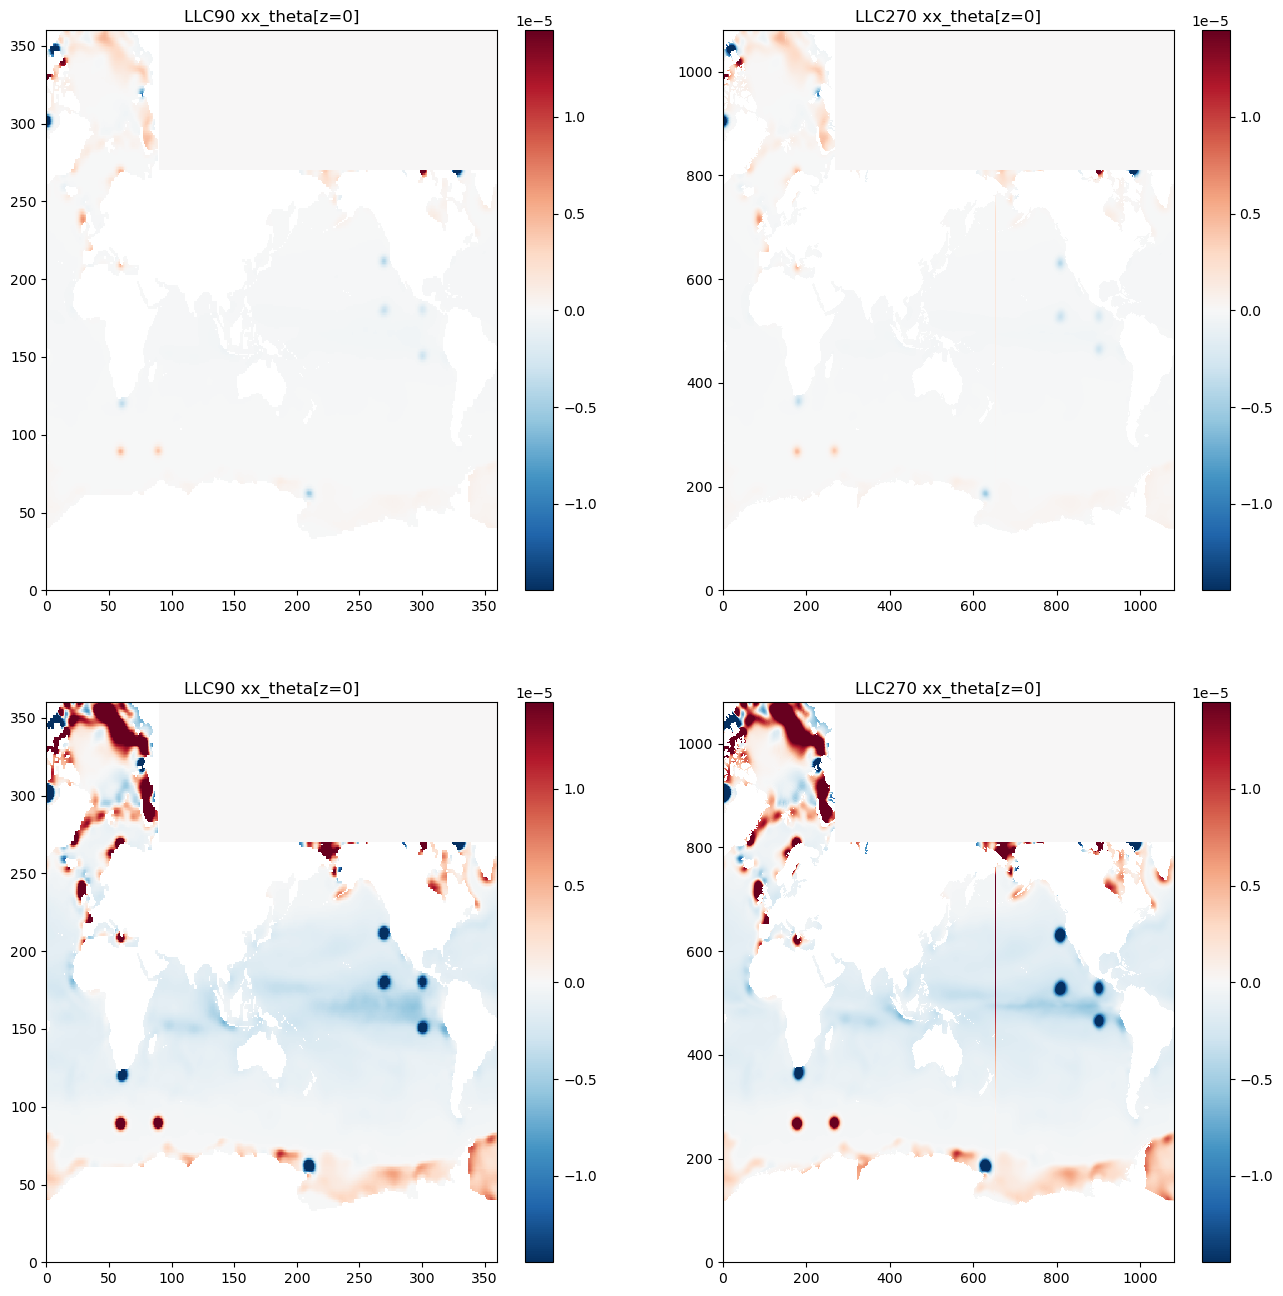

In [31]:

fig, axes = plt.subplots(2, 2, figsize=(16,16))
axes = axes.ravel()  # Flatten the 2D array of axes for easy indexing


xx_theta[xx_theta == 0] = np.nan
xx_theta_lrcost[xx_theta_lrcost == 0] = np.nan
xx_theta_hr[xx_theta_hr == 0] = np.nan
xx_theta_hr_lrcost[xx_theta_hr_lrcost == 0] = np.nan


vmax = np.nanmax(abs(xx_theta_hr))/10
vmin = -vmax

ax = axes[0]
mesh = ax.pcolormesh(patchface3D(xx_theta[0,:,:], nx, 1)[0,:,:], cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_title('LLC90 xx_theta[z=0]')
fig.colorbar(mesh, ax=ax)


ax = axes[1]
mesh = ax.pcolormesh(patchface3D(xx_theta_hr[0,:,:], nxh, 1)[0,:,:], cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_title('LLC270 xx_theta[z=0]')
fig.colorbar(mesh, ax=ax)

ax = axes[2]
mesh = ax.pcolormesh(patchface3D(xx_theta_lrcost[0,:,:], nx, 1)[0,:,:], cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_title('LLC90 xx_theta[z=0]')
fig.colorbar(mesh, ax=ax)


ax = axes[3]
mesh = ax.pcolormesh(patchface3D(xx_theta_hr_lrcost[0,:,:], nxh, 1)[0,:,:], cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_title('LLC270 xx_theta[z=0]')
fig.colorbar(mesh, ax=ax)

In [33]:
# write_float32(dirrun_pup + 'xx_hires/xx_aqh.000000' + iter + '.data', xx_aqh_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_atemp.000000' + iter + '.data', xx_atemp_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_diffkr.000000' + iter + '.data', xx_diffkr_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_etan.000000' + iter + '.data', xx_etan_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_kapgm.000000' + iter + '.data', xx_kapgm_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_kapredi.000000' + iter + '.data', xx_kapredi_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_lwdown.000000' + iter + '.data', xx_lwdown_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_precip.000000' + iter + '.data', xx_precip_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_swdown.000000' + iter + '.data', xx_swdown_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_tauu.000000' + iter + '.data', xx_tauu_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_tauv.000000' + iter + '.data', xx_tauv_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_uvel.000000' + iter + '.data', xx_uvel_hr)
# write_float32(dirrun_pup + 'xx_hires/xx_vvel.000000' + iter + '.data', xx_vvel_hr)

write_float32(dirrun_pup + 'xx_hires/xx_salt.000000' + iter + '.data', xx_salt_hr)
write_float32(dirrun_pup + 'xx_hires/xx_theta.000000' + iter + '.data', xx_theta_hr)


write_float32(dirrun_pup_lr_cost + 'xx_hires/xx_salt.000000' + iter + '.data', xx_salt_hr_lrcost)
write_float32(dirrun_pup_lr_cost + 'xx_hires/xx_theta.000000' + iter + '.data', xx_theta_hr_lrcost)


# Bathymetry

In [ ]:
bathy_lr = read_float32('/nobackup/owang/runs/V4r4/ancillary_data/ancillary_data_orig//input_init/bathy_eccollc_90x50_min2pts.bin').reshape(ny, nx)
bathy_hr = read_float32('/nobackup/owang/runs/MG/llc270/input.extra/llc270/input/input_init/bathy270_filled_noCaspian_r4').reshape(nyh, nxh)

bathy_lr = patchface3D(bathy_lr, nx, 1)[0,:,:]

resized_array = np.repeat(np.repeat(bathy_lr, 3, axis=0), 3, axis=1)


plt.pcolormesh(resized_array)
plt.colorbar()
plt.show()

plt.pcolormesh(patchface3D(bathy_hr, nxh, 1)[0,:,:])
plt.colorbar()
plt.show()


In [ ]:
tmp = patchface3D(bathy_hr, nxh, 1)[0,:,:] - resized_array
tmp[tmp == 0] = np.nan

plt.pcolormesh(tmp)
plt.colorbar()
plt.show()

In [ ]:
depth_lr = rdmds('/nobackup/sreich/multigrid_test_ou/c68w/llc90/run.v4_rls4.077d3.pack_unpack/Depth')
depth_hr = rdmds('/nobackup/sreich/multigrid_test_ou/c68w/llc270/run.fwd_270.076c.iter0/Depth')


hfacc_lr = rdmds('/nobackup/sreich/multigrid_test_ou/c68w/llc90/run.v4_rls4.077d3.pack_unpack/hFacC')
hfacc_hr = rdmds('/nobackup/sreich/multigrid_test_ou/c68w/llc270/run.fwd_270.076c.iter0/hFacC')

# plt.pcolormesh(patchface3D(depth_lr, nx, 1)[0,:,:] + patchface3D(bathy_lr, nx, 1)[0,:,:])
# plt.colorbar()
# plt.show()

plt.pcolormesh(patchface3D(depth_hr, nxh, 1)[0,:,:] + patchface3D(bathy_hr, nxh, 1)[0,:,:])
plt.colorbar()
plt.show()

In [ ]:
hfacc_lr[hfacc_lr > 0] = 1
hfacc_hr[hfacc_hr > 0] = 1



In [ ]:
len(xx_theta_hr[xx_theta_hr == 0]), len(hfacc_hr[hfacc_hr == 0])


In [ ]:
np.unique(xx_theta == np.nan)